Clustering

In [26]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import folium
from geopy.distance import great_circle
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.spatial import ConvexHull


In [2]:
data = pd.read_csv("Paid_Parking_Occupancy__Last_30_Days__20240114.csv")

In [3]:
data.head()

,OccupancyDateTime,PaidOccupancy,BlockfaceName,SideOfStreet,SourceElementKey,ParkingTimeLimitCategory,ParkingSpaceCount,PaidParkingArea,PaidParkingSubArea,PaidParkingRate,ParkingCategory,Location
0,12/20/2023 12:23:00 PM,2,4TH AVE BETWEEN LENORA ST AND BLANCHARD ST,NE,74030,120,4,Belltown,South,NaN,Paid Parking,POINT (-122.34189516 47.61428003)
1,12/20/2023 03:36:00 PM,2,REPUBLICAN ST BETWEEN PONTIUS AVE N AND YALE A...,S,35202,120,7,South Lake Union,South,NaN,Paid Parking,POINT (-122.33110643 47.62305276)
2,12/20/2023 02:32:00 PM,2,UNIVERSITY ST BETWEEN 4TH AVE AND 5TH AVE,NW,13189,120,2,Commercial Core,Retail,NaN,Paid Parking,POINT (-122.33435292 47.60852356)
3,12/20/2023 07:02:00 PM,2,EAST GREEN LAKE WAY N BETWEEN 4TH AVE NE AND N...,SE,36678,120,5,Green Lake,NaN,NaN,Paid Parking,POINT (-122.32641739 47.67867099)
4,12/20/2023 03:32:00 PM,1,BROADWAY CT BETWEEN E MADISON ST AND E SENECA ST,E,54754,240,6,Pike-Pine,NaN,NaN,Paid Parking,POINT (-122.31980299 47.61188096)


In [4]:
data.drop(['OccupancyDateTime','PaidOccupancy','BlockfaceName','SideOfStreet','ParkingTimeLimitCategory','ParkingSpaceCount','PaidParkingSubArea','ParkingCategory','PaidParkingRate'],axis=1,inplace=True)

In [5]:
data.head()

,SourceElementKey,PaidParkingArea,Location
0,74030,Belltown,POINT (-122.34189516 47.61428003)
1,35202,South Lake Union,POINT (-122.33110643 47.62305276)
2,13189,Commercial Core,POINT (-122.33435292 47.60852356)
3,36678,Green Lake,POINT (-122.32641739 47.67867099)
4,54754,Pike-Pine,POINT (-122.31980299 47.61188096)


In [7]:
# Extracting longitude and latitude from the 'Location' column
data[['Longitude', 'Latitude']] = data['Location'].str.extract(r'POINT \((-?\d+\.\d+) (-?\d+\.\d+)\)')

# Convert extracted coordinates to numeric values
data['Longitude'] = pd.to_numeric(data['Longitude'])
data['Latitude'] = pd.to_numeric(data['Latitude'])

# Selecting rows with unique longitude and latitude coordinates
unique_coordinates = data[['Longitude', 'Latitude']].drop_duplicates()

# Displaying the first few rows of the unique coordinates
unique_coordinates.head()


,Longitude,Latitude
0,-122.341895,47.614280
1,-122.331106,47.623053
2,-122.334353,47.608524
3,-122.326417,47.678671
4,-122.319803,47.611881


In [10]:

# Selecting only the Longitude and Latitude columns for clustering
X = unique_coordinates[['Longitude', 'Latitude']]

# Using the Elbow Method to find the optimal number of clusters
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

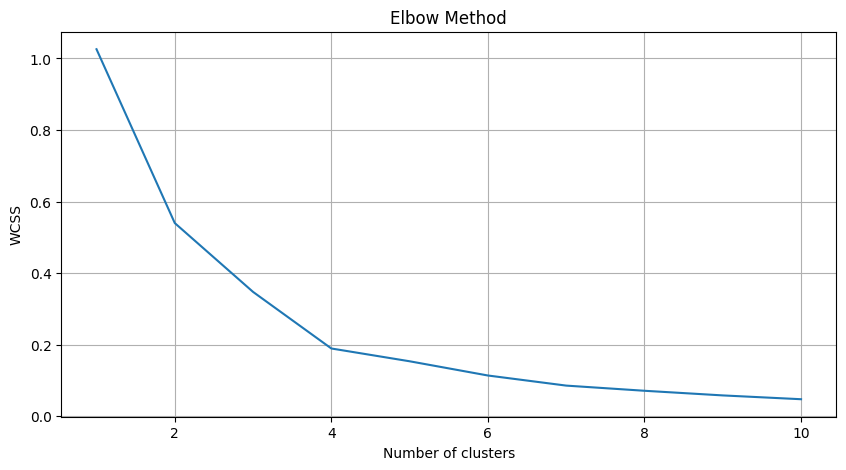

In [11]:
# Plotting the results onto a line graph to observe the 'elbow'
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.grid(True)
plt.show()

In [16]:


# Performing K-Means clustering
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans.fit_predict(X)

# Adding the cluster labels to our dataframe
unique_coordinates['Cluster'] = clusters

# Finding the center of each cluster for plotting
cluster_centers = kmeans.cluster_centers_





In [18]:

# Initialize a map
map_clusters = folium.Map(location=[unique_coordinates['Latitude'].mean(), unique_coordinates['Longitude'].mean()], zoom_start=10)

# Colors for different clusters
colors = ['red', 'blue', 'green', 'purple', 'orange']
# Add markers to the map for each cluster center
for idx, location in enumerate(cluster_centers):
    folium.CircleMarker(
        [location[1], location[0]],
        radius=10,
        color=colors[idx],
        fill=True,
        fill_color=colors[idx],
        fill_opacity=0.7,
        popup=f'Cluster {idx}'
    ).add_to(map_clusters)

# Show the map
map_clusters.save('clusters_map.html')
map_clusters


In [21]:


# Function to calculate the farthest point in each cluster from the center
def calculate_cluster_radius(cluster_center, cluster_points):
    distances = [great_circle(cluster_center, point).kilometers for point in cluster_points]
    return max(distances)

# Initialize a new map
map_clusters = folium.Map(location=[unique_coordinates['Latitude'].mean(), unique_coordinates['Longitude'].mean()], zoom_start=10)

# Iterate over each cluster
for cluster_num in range(kmeans.n_clusters):
    # Extract the points in this cluster
    cluster_points = unique_coordinates[unique_coordinates['Cluster'] == cluster_num][['Latitude', 'Longitude']]
    cluster_center = cluster_centers[cluster_num]
    
    # Calculate the radius of the cluster
    radius = calculate_cluster_radius(cluster_center[::-1], cluster_points.to_numpy().tolist())

    # Draw a circle around the cluster
    folium.Circle(
        location=(cluster_center[1], cluster_center[0]),
        radius=radius * 1000,  # Convert radius to meters
        color=colors[cluster_num],
        fill=True,
        fill_color=colors[cluster_num],
        fill_opacity=0.2
    ).add_to(map_clusters)

# Save and display the map
map_clusters.save('clusters_map_with_radius.html')
map_clusters



In [22]:


# Standardize the data before applying DBSCAN
X_scaled = StandardScaler().fit_transform(X)

# Apply DBSCAN clustering
# eps is the maximum distance between two samples for them to be considered as in the same neighborhood
# min_samples is the number of samples in a neighborhood for a point to be considered as a core point
dbscan = DBSCAN(eps=0.3, min_samples=10)
clusters_dbscan = dbscan.fit_predict(X_scaled)

# Insert the DBSCAN cluster labels into the dataframe
unique_coordinates['DBSCAN_Cluster'] = clusters_dbscan

# Number of clusters in labels, ignoring noise if present
n_clusters_ = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
n_noise_ = list(clusters_dbscan).count(-1)

n_clusters_, n_noise_


(7, 9)

In [23]:


# Initialize a new map
map_dbscan = folium.Map(location=[unique_coordinates['Latitude'].mean(), unique_coordinates['Longitude'].mean()], zoom_start=10)

# Iterate over each cluster identified by DBSCAN
for cluster_num in range(n_clusters_):
    # Extract the points in this cluster
    cluster_points = unique_coordinates[unique_coordinates['DBSCAN_Cluster'] == cluster_num][['Latitude', 'Longitude']]
    
    # If there are enough points for a convex hull, draw it
    if cluster_points.shape[0] > 2:
        # Calculate the convex hull for the cluster
        hull = ConvexHull(cluster_points)
        hull_points = cluster_points.iloc[hull.vertices]
        
        # Create a polygon for the hull
        folium.Polygon(
            locations=hull_points,
            color=colors[cluster_num % len(colors)],
            fill=True,
            fill_color=colors[cluster_num % len(colors)],
            fill_opacity=0.3,
        ).add_to(map_dbscan)
    else:
        # There are not enough points for a convex hull, plot them as markers
        for point in cluster_points.to_numpy():
            folium.CircleMarker(
                location=(point[0], point[1]),
                radius=5,
                color=colors[cluster_num % len(colors)],
                fill=True,
                fill_color=colors[cluster_num % len(colors)],
                fill_opacity=1
            ).add_to(map_dbscan)

# Add noise points as black markers
noise_points = unique_coordinates[unique_coordinates['DBSCAN_Cluster'] == -1][['Latitude', 'Longitude']]
for point in noise_points.to_numpy():
    folium.CircleMarker(
        location=(point[0], point[1]),
        radius=3,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=1
    ).add_to(map_dbscan)

# Save and display the map
map_dbscan.save('dbscan_clusters_map.html')
map_dbscan
